<a href="https://colab.research.google.com/github/andy5209/ML2021hw/blob/main/HW02/HW02-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task,
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [1]:
!gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!unzip data.zip
!ls

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR
From (redirected): https://drive.google.com/uc?id=1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR&confirm=t&uuid=608b08dc-ccf9-4cba-8103-08cb95513361
To: /content/data.zip
100% 372M/372M [00:03<00:00, 120MB/s]
Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  sample_data  timit_11


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [2]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


## Create Dataset

In [6]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [7]:
VAL_RATIO = 0.2

percent = int(train.shape[0] * (1 - VAL_RATIO))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: (983945, 429)
Size of validation set: (245987, 429)


Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [8]:
BATCH_SIZE = 64

from torch.utils.data import DataLoader

train_set = TIMITDataset(train_x, train_y)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [9]:
import gc

del train, train_label, train_x, train_y, val_x, val_y
gc.collect()

87

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [17]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(429, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 39)

        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)

        x = self.out(x)

        return x

## Training

In [18]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [19]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [20]:
# fix random seed for reproducibility
same_seeds(0)

# get device
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 20               # number of training epoch
learning_rate = 0.0001       # learning rate

# the path where checkpoint saved
model_path = './model.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [21]:
# start training

#儲存準確度、loss數
Train_Acc = [] # 初始化一個空列表，用於儲存每個 epoch 的訓練準確度
Train_loss = [] # 初始化一個空列表，用於儲存每個 epoch 的訓練損失
Val_Acc = [] # 初始化一個空列表，用於儲存每個 epoch 的驗證準確度
Val_loss = [] # 初始化一個空列表，用於儲存每個 epoch 的驗證損失

best_acc = 0.0 # 初始化最佳驗證準確度為 0.0，用於儲存最好的模型
# early stopping parameters
early_stop_cnt = 0 # 初始化 early stopping 的計數器
best_loss = float('inf')  # 初始化最佳驗證損失為無限大，用於追蹤最低損失

for epoch in range(num_epoch): # 迴圈遍歷指定的 epoch 次數
    train_acc = 0.0 # 初始化當前 epoch 的訓練準確度為 0.0
    train_loss = 0.0 # 初始化當前 epoch 的訓練損失為 0.0
    val_acc = 0.0 # 初始化當前 epoch 的驗證準確度為 0.0
    val_loss = 0.0 # 初始化當前 epoch 的驗證損失為 0.0

    # training
    model.train() # 將模型設定為訓練模式 (啟用 Dropout 和 Batch Normalization 等)
    for i, data in enumerate(train_loader): # 迴圈遍歷訓練資料集中的每個 batch
        inputs, labels = data # 從 batch 中取出輸入資料和標籤
        inputs, labels = inputs.to(device), labels.to(device) # 將輸入資料和標籤移動到指定的設備 (CPU 或 GPU)
        optimizer.zero_grad() # 清除之前計算的梯度
        outputs = model(inputs) # 將輸入資料傳入模型進行前向傳播，得到預測輸出
        batch_loss = criterion(outputs, labels) # 計算當前 batch 的損失
        _, train_pred = torch.max(outputs, 1) # 找到每個樣本預測輸出中機率最大的類別索引作為預測結果
        batch_loss.backward() # 執行反向傳播，計算梯度
        optimizer.step() # 根據計算出的梯度更新模型參數

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item() # 計算當前 batch 的訓練準確度並累加
        train_loss += batch_loss.item() # 累加當前 batch 的訓練損失

    # validation
    if len(val_set) > 0: # 如果驗證集的大小大於 0 (存在驗證集)
        model.eval() # 將模型設定為評估模式 (關閉 Dropout 等)
        with torch.no_grad(): # 在評估模式下，不計算梯度，以節省記憶體和計算時間
            for i, data in enumerate(val_loader): # 迴圈遍歷驗證資料集中的每個 batch
                inputs, labels = data # 從 batch 中取出輸入資料和標籤
                inputs, labels = inputs.to(device), labels.to(device) # 將輸入資料和標籤移動到指定的設備
                outputs = model(inputs) # 將輸入資料傳入模型進行前向傳播，得到預測輸出
                batch_loss = criterion(outputs, labels) # 計算當前 batch 的損失
                _, val_pred = torch.max(outputs, 1) # 找到每個樣本預測輸出中機率最大的類別索引作為預測結果

                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # 計算當前 batch 的驗證準確度並累加
                val_loss += batch_loss.item() # 累加當前 batch 的驗證損失

            Train_Acc.append(train_acc/len(train_set)) # 將當前 epoch 的訓練準確度 (平均值) 加入列表
            Train_loss.append(train_loss/len(train_loader)) # 將當前 epoch 的訓練損失 (平均值) 加入列表
            Val_Acc.append(val_acc/len(val_set)) # 將當前 epoch 的驗證準確度 (平均值) 加入列表
            Val_loss.append(val_loss/len(val_loader)) # 將當前 epoch 的驗證損失 (平均值) 加入列表

            current_val_loss = val_loss / len(val_loader) # 計算當前 epoch 的平均驗證損失

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), current_val_loss
            )) # 打印當前 epoch 的訓練和驗證準確度及損失

            # Check for early stopping based on validation loss
            if current_val_loss < best_loss: # 如果當前驗證損失低於之前記錄的最佳驗證損失
                best_loss = current_val_loss # 更新最佳驗證損失
                early_stop_cnt = 0  # Reset counter，重置 early stopping 計數器
                # if the model improves based on accuracy, save a checkpoint at this epoch
                if val_acc > best_acc: # 如果當前驗證準確度優於之前記錄的最佳驗證準確度
                    best_acc = val_acc # 更新最佳驗證準確度
                    torch.save(model.state_dict(), model_path) # 儲存當前模型的狀態字典 (模型參數) 到指定的路徑
                    print('saving model with acc {:.3f}'.format(best_acc/len(val_set))) # 打印儲存模型的訊息和最佳驗證準確度
            else: # 如果當前驗證損失沒有降低
                early_stop_cnt += 1 # early stopping 計數器加一
                print(f'EarlyStop counter: {early_stop_cnt}') # 打印當前 early stopping 計數器的值

            if early_stop_cnt >= 3: # Default early stop count - 如果 early stopping 計數器達到或超過設定的閾值 (200)
                print('Early stopping!') # 打印 early stopping 的訊息
                break # Stop the training loop，終止訓練迴圈

    else: # 如果不存在驗證集
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        )) # 只打印當前 epoch 的訓練準確度及損失

# if not validating, save the last epoch
if len(val_set) == 0: # 如果不存在驗證集
    torch.save(model.state_dict(), model_path) # 儲存最後一個 epoch 的模型狀態字典
    print('saving model at last epoch') # 打印儲存模型的訊息

[001/020] Train Acc: 0.620560 Loss: 1.227387 | Val Acc: 0.676967 loss: 1.021401
saving model with acc 0.677
[002/020] Train Acc: 0.691039 Loss: 0.965276 | Val Acc: 0.694211 loss: 0.948822
saving model with acc 0.694
[003/020] Train Acc: 0.717265 Loss: 0.870527 | Val Acc: 0.704033 loss: 0.912161
saving model with acc 0.704
[004/020] Train Acc: 0.736584 Loss: 0.803474 | Val Acc: 0.709724 loss: 0.895939
saving model with acc 0.710
[005/020] Train Acc: 0.752753 Loss: 0.749148 | Val Acc: 0.712501 loss: 0.885235
saving model with acc 0.713
[006/020] Train Acc: 0.766273 Loss: 0.702461 | Val Acc: 0.715509 loss: 0.879350
saving model with acc 0.716
[007/020] Train Acc: 0.779200 Loss: 0.660716 | Val Acc: 0.712570 loss: 0.900117
EarlyStop counter: 1
[008/020] Train Acc: 0.790388 Loss: 0.622605 | Val Acc: 0.714721 loss: 0.903897
EarlyStop counter: 2
[009/020] Train Acc: 0.801848 Loss: 0.586546 | Val Acc: 0.709960 loss: 0.924511
EarlyStop counter: 3
Early stopping!


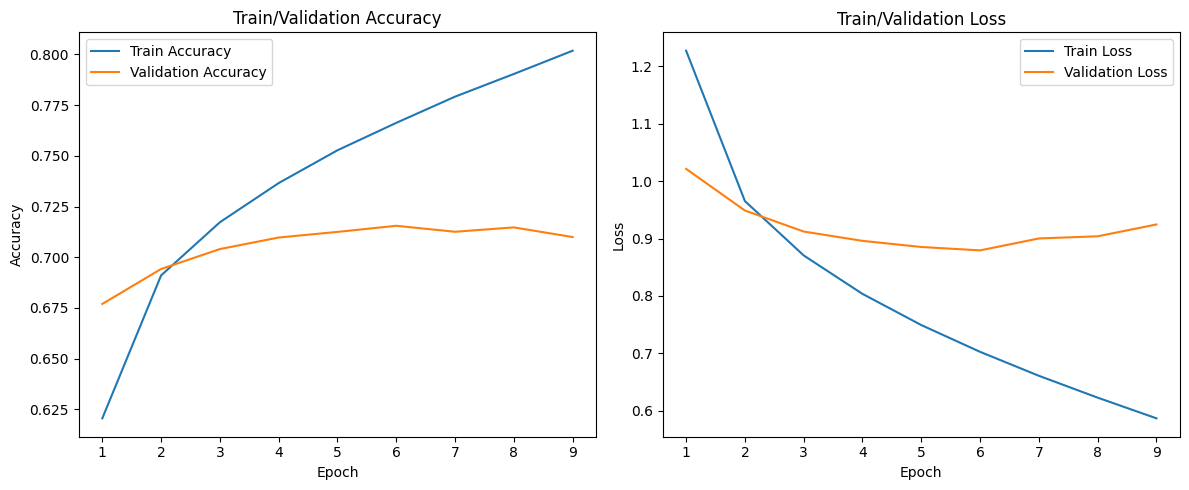

In [22]:
# 將ReLU畫成圖
epochs = list(range(1, len(Train_Acc) + 1)) # Use the length of Train_Acc to determine the number of epochs
# 畫圖
import matplotlib.pyplot as plt # Import matplotlib.pyplot

plt.figure(figsize=(12, 5))

# 準確率圖
plt.subplot(1, 2, 1)
plt.plot(epochs, Train_Acc, label='Train Accuracy') # Use Train_Acc
plt.plot(epochs, Val_Acc, label='Validation Accuracy') # Use Val_Acc
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy')
plt.legend()

# 損失圖
plt.subplot(1, 2, 2)
plt.plot(epochs, Train_loss, label='Train Loss') # Use Train_loss
plt.plot(epochs, Val_loss, label='Validation Loss') # Use Val_loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

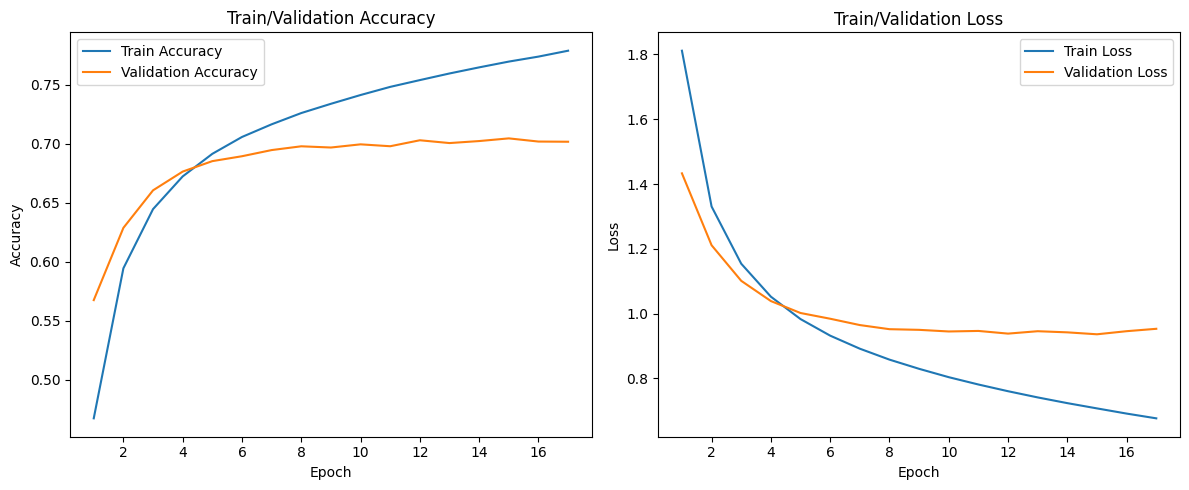

In [16]:
# 將Sigmoid畫成圖
epochs = list(range(1, len(Train_Acc) + 1)) # Use the length of Train_Acc to determine the number of epochs
# 畫圖
import matplotlib.pyplot as plt # Import matplotlib.pyplot

plt.figure(figsize=(12, 5))

# 準確率圖
plt.subplot(1, 2, 1)
plt.plot(epochs, Train_Acc, label='Train Accuracy') # Use Train_Acc
plt.plot(epochs, Val_Acc, label='Validation Accuracy') # Use Val_Acc
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train/Validation Accuracy')
plt.legend()

# 損失圖
plt.subplot(1, 2, 2)
plt.plot(epochs, Train_loss, label='Train Loss') # Use Train_loss
plt.plot(epochs, Val_loss, label='Validation Loss') # Use Val_loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train/Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

Make prediction.

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
with open('prediction.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))